In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro, kruskal
import scikit_posthocs as sp


%load_ext autoreload
%autoreload 2


file_name = 'ridesharing.csv'




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
f_rates = pd.DataFrame()


df = pd.read_csv(file)
df = df.dropna(subset="dropoff_time") # drop car agents


fulfilled = df[df["dropoff_time"] != -1] # passengers whose requests were fulfilled
unique_fulfilled = fulfilled.drop_duplicates(subset=['seed_int', 'iteration', 'num_drivers', 'strategy', 'AgentID'], keep='last')

unique_df = df.drop_duplicates(subset=['seed_int', 'iteration', 'num_drivers', 'strategy', 'AgentID'], keep='last')


for strategy in ["StepType.CLOSEST", "StepType.QUEUE", "StepType.WAITING"]:
    for i in range(1,6):

        num_fulfilled = len(unique_fulfilled[(unique_fulfilled["strategy"] == strategy) & (unique_fulfilled["num_drivers"] == i)])

        total = len(unique_df[(unique_df["strategy"] == strategy) & (unique_df["num_drivers"] == i)])

        f_rate = (num_fulfilled/total) * 100

        f_rates = f_rates.append({'Strategy': strategy, 'num_drivers': i, 'f_rate': f_rate}, ignore_index=True)


f_rates


C:\Users\lokhe\AppData\Local\Temp\ipykernel_18104\4231089168.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f_rates = f_rates.append({'Strategy': strategy, 'num_drivers': i, 'f_rate': f_rate, 'file': file}, ignore_index=True)
C:\Users\lokhe\AppData\Local\Temp\ipykernel_18104\4231089168.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f_rates = f_rates.append({'Strategy': strategy, 'num_drivers': i, 'f_rate': f_rate, 'file': file}, ignore_index=True)
C:\Users\lokhe\AppData\Local\Temp\ipykernel_18104\4231089168.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f_rates = f_rates.append({'Strategy': strategy, 'num_drivers': i, 'f_rate': f_rate, 'file': file}, ignore_index=True)
C:\Users\lokhe\AppData\Local\Temp\ipy

FileNotFoundError: [Errno 2] No such file or directory: 'ridehailing.csv'

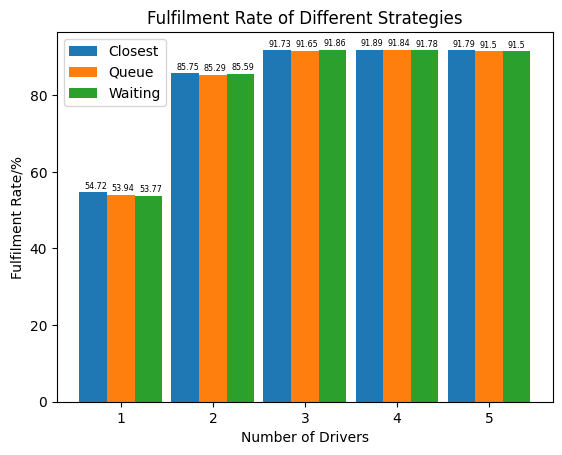

In [4]:
f_rates

labels = [i for i in range (1,6)]
f_rates_list = f_rates['f_rate'].tolist()
closest = f_rates_list[:5]
queue = f_rates_list[5:10]
waiting = f_rates_list[10:]

# Define the bar width
bar_width = 0.3

# Create a figure and axis object
fig, ax = plt.subplots()


ax.bar(np.arange(len(labels)), closest, width=bar_width, label='Closest')
ax.bar(np.arange(len(labels)) + bar_width, queue, width=bar_width, label='Queue')
ax.bar(np.arange(len(labels)) + 2 * bar_width, waiting, width=bar_width, label='Waiting')


# Set the x-axis labels and tick marks
ax.set_xticks(np.arange(len(labels)) + bar_width)
ax.set_xticklabels(labels)

# Add a legend
ax.legend()

plt.xlabel('Number of Drivers')
plt.ylabel('Fulfilment Rate/%')
plt.title('Fulfilment Rate of Different Strategies')


for i in range(len(closest)):
    ax.text(i - 0.1, closest[i] + 1, str(round(closest[i], 2)), fontsize='xx-small')
    ax.text(i + bar_width - 0.1, queue[i] + 1, str(round(queue[i], 2)), fontsize='xx-small')
    ax.text(i + 2 * bar_width - 0.1, waiting[i] + 1, str(round(waiting[i], 2)), fontsize='xx-small')


# Display the plot
plt.savefig('figures/f_rate.png')



## stats testing

In [5]:
f_rates_norm = pd.DataFrame(columns=['Strategy', 'num_drivers', 'Iteration', 'Seed_int', 'f_rate'])

for strategy in ["StepType.CLOSEST", "StepType.QUEUE", "StepType.WAITING"]:
    for i in range(1,6):
        for seed_int in unique_df['seed_int'].unique():
            for iteration in unique_df['iteration'].unique():
                num_fulfilled = len(unique_fulfilled[(unique_fulfilled["strategy"] == strategy) & (unique_fulfilled["num_drivers"] == i) & (unique_fulfilled['seed_int'] == seed_int) & (unique_fulfilled['iteration'] == iteration)])
                total = len(unique_df[(unique_df["strategy"] == strategy) & (unique_df["num_drivers"] == i) & (unique_df['seed_int'] == seed_int) & (unique_df['iteration'] == iteration)])
                f_rate = (num_fulfilled/total) * 100
                f_rates_norm.loc[len(f_rates_norm)] = {'Strategy': strategy, 'num_drivers': i, 'Iteration': iteration, 'Seed_int': seed_int, 'f_rate': f_rate}



f_rates_norm
# unique_fulfilled

,Strategy,num_drivers,Iteration,Seed_int,f_rate
0,StepType.CLOSEST,1,0,54,56.551724
1,StepType.CLOSEST,1,1,54,54.482759
2,StepType.CLOSEST,1,2,54,54.482759
3,StepType.CLOSEST,1,3,54,52.413793
4,StepType.CLOSEST,1,4,54,55.172414
...,...,...,...,...,...
745,StepType.WAITING,5,0,578,94.630872
746,StepType.WAITING,5,1,578,90.604027
747,StepType.WAITING,5,2,578,91.275168
748,StepType.WAITING,5,3,578,91.946309


In [6]:
# the null hypothesis of the test is that the data is drawn from a normal distribution.
# If the p-value is less than some predetermined significance level (e.g., 0.05), 
# we would reject the null hypothesis and conclude that the data is not normally distributed.
for strategy in ["StepType.CLOSEST", "StepType.QUEUE", "StepType.WAITING"]:
    for i in range(1,6):
        group = f_rates_norm[(f_rates_norm["Strategy"] == strategy) & (f_rates_norm["num_drivers"] == i)]

        
        stat, p = shapiro(group["f_rate"])

        # Print the test statistic and p-value
        print("Shapiro-Wilk test statistic:", stat)
        print("p-value:", p)
        if p < 0.05:
            print("Reject", strategy, i)

Shapiro-Wilk test statistic: 0.9597750306129456
p-value: 0.08698394149541855
Shapiro-Wilk test statistic: 0.9866739511489868
p-value: 0.8404966592788696
Shapiro-Wilk test statistic: 0.9743865728378296
p-value: 0.34569960832595825
Shapiro-Wilk test statistic: 0.9485084414482117
p-value: 0.02963564544916153
Reject StepType.CLOSEST 4
Shapiro-Wilk test statistic: 0.9730544686317444
p-value: 0.30675071477890015
Shapiro-Wilk test statistic: 0.9482938051223755
p-value: 0.029043138027191162
Reject StepType.QUEUE 1
Shapiro-Wilk test statistic: 0.9543328285217285
p-value: 0.051532018929719925
Shapiro-Wilk test statistic: 0.9728498458862305
p-value: 0.30110758543014526
Shapiro-Wilk test statistic: 0.9805821180343628
p-value: 0.5767629146575928
Shapiro-Wilk test statistic: 0.978489339351654
p-value: 0.49016034603118896
Shapiro-Wilk test statistic: 0.9744614362716675
p-value: 0.3480050563812256
Shapiro-Wilk test statistic: 0.9735223650932312
p-value: 0.31999126076698303
Shapiro-Wilk test statistic:

In [7]:
# not normal, so use kruskal 

for i in range(1,6):
    group1 = f_rates_norm[(f_rates_norm["Strategy"] == "StepType.CLOSEST") & (f_rates_norm["num_drivers"] == i)]['f_rate']
    group2 = f_rates_norm[(f_rates_norm["Strategy"] == "StepType.QUEUE") & (f_rates_norm["num_drivers"] == i)]['f_rate']
    group3 = f_rates_norm[(f_rates_norm["Strategy"] == "StepType.WAITING") & (f_rates_norm["num_drivers"] == i)]['f_rate']

    stat, p = kruskal(group1, group2, group3)

    print('Statistics=%.3f, p=%f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Samples look to be drawn from the same distributions (fail to reject H0)')
    else:
        print('Samples look to be drawn from different distributions (reject H0)')

Statistics=5.369, p=0.068260
Samples look to be drawn from the same distributions (fail to reject H0)
Statistics=0.440, p=0.802379
Samples look to be drawn from the same distributions (fail to reject H0)
Statistics=0.359, p=0.835813
Samples look to be drawn from the same distributions (fail to reject H0)
Statistics=0.068, p=0.966469
Samples look to be drawn from the same distributions (fail to reject H0)
Statistics=0.397, p=0.819756
Samples look to be drawn from the same distributions (fail to reject H0)


In [8]:
# posthoc analysus - pairwise t test use dunns test for non-parametric data
data = f_rates_norm[(f_rates_norm["num_drivers"] == 1)]



p_values= sp.posthoc_dunn(data,val_col='f_rate', group_col='Strategy', p_adjust = 'bonferroni')
 
print(p_values)


# # perform post-hoc Dunn's test with Bonferroni correction
# groups = np.concatenate((np.repeat('group1', 20), np.repeat('group2', 20), np.repeat('group3', 20)))
# data = pd.DataFrame({'value': np.concatenate((group1, group2, group3)), 'group': groups})

# dunn_results = posthoc_dunn(data, val_col='value', group_col='group', p_adjust='bonferroni')
# print(dunn_results).


                  StepType.CLOSEST  StepType.QUEUE  StepType.WAITING
StepType.CLOSEST          1.000000        0.226665          0.088614
StepType.QUEUE            0.226665        1.000000          1.000000
StepType.WAITING          0.088614        1.000000          1.000000
